In [1]:
%matplotlib inline
import numpy as np
import sqlite3
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
from collections import Counter

## Unsupervised Learning Capstone

The goal of this capstone project is to 1) scrape some articles from various web sources, 2) clean that data and fit it nicely into a workable data frame, and 3) model and cluster that data to see if we can identify any meaningful trends.

Step one of this goal was achieved by finding a rather thoughtfully curated database containing news articles from several different publications on a wide array of topics. This database was parsed and processed using SQL.

In [2]:
##importing the database
path = 'C:\\Users\\Aaron\\Desktop\\'
database = path + 'all-the-news.db'
cnx = sqlite3.connect(database)

news = pd.read_sql('SELECT * FROM longform', cnx)

In [3]:
##drop null fields
news = news.dropna(subset=['author'])

In [4]:
##clean up the strings in the author column
author_clean = []
for x in news['author']:
    x = re.sub('\\n','', x)
    author_clean.append(x)
    
news['author'] = author_clean

A bit of cleaning was necessary for formatting purposes, but overall the database was very well maintained.

In [5]:
news.head()

,id,title,author,date,content,year,month,publication,category,digital,section,url
0,1,Agent Cooper in Twin Peaks is the audience: on...,Tasha Robinson,2017-05-31,And never more so than in Showtime’s new...,2017,5,Verge,Longform,1.0,None,None
1,2,"AI, the humanity!",Sam Byford,2017-05-30,AlphaGo’s victory isn’t a defeat for hum...,2017,5,Verge,Longform,1.0,None,None
2,3,The Viral Machine,Kaitlyn Tiffany,2017-05-25,Super Deluxe built a weird internet empi...,2017,5,Verge,Longform,1.0,None,None
3,4,How Anker is beating Apple and Samsung at thei...,Nick Statt,2017-05-22,Steven Yang quit his job at Google in th...,2017,5,Verge,Longform,1.0,None,None
4,5,Tour Black Panther’s reimagined homeland with ...,Kwame Opam,2017-05-15,Ahead of Black Panther’s 2018 theatrical...,2017,5,Verge,Longform,1.0,None,None


There are several different types of articles, they differ on medium (print, digital, newspaper, etc) as well as content. I chose to focus on one categorization to make the clustering a bit more meaningful - one would assume clustering cooking and music articles would be a simple task.

In [6]:
##get the subset of articles only discussing film
film = news.loc[news['section']=='film']

In [7]:
len(film)

502

In [8]:
film.author.value_counts().head(10)

Peter Bradshaw      68
Benjamin Lee        42
Nigel M Smith       41
Catherine Shoard    36
Jordan Hoffman      34
Andrew Pulver       26
Ben Child           25
Gwilym Mumford      22
Ryan Gilbey         10
Xan Brooks           7
Name: author, dtype: int64

I selected film articles because there wasn't an overwhelming amount of data to parse, and I thought that film was an artistic enough category that the folks who wrote about movies might have some distinguishing prose. This is in contrast to technical writing - for example, I don't imagine there's too many different ways to write an instruction manual for operating a washing machine.

In [9]:
##from that subset, take the subset of only the 10 most prolific authors
pb = film.loc[film.author=='Peter Bradshaw']
bl = film.loc[film.author=='Benjamin Lee']
ns = film.loc[film.author=='Nigel M Smith']
cs = film.loc[film.author=='Catherine Shaord']
jh = film.loc[film.author=='Jordan Hoffman']
ap = film.loc[film.author=='Andrew Pulver']
bc = film.loc[film.author=='Ben Child']
gm = film.loc[film.author=='Gwilym Mumford']
rg = film.loc[film.author=='Ryan Gilbey']
sh = film.loc[film.author=='Stuart Heritage']

In [10]:
films = pd.concat([pb, bl, ns, cs, jh, ap, bc, gm, rg, sh])

In [11]:
films.head()

,id,title,author,date,content,year,month,publication,category,digital,section,url
116763,145705,Kong: Skull Island review – only de-evolution ...,Peter Bradshaw,2017-03-02,Deep in the distant jungle … the undergrowth s...,2017,3,Guardian,newspaper,0.0,film,https://www.theguardian.com/film/2017/mar/02/k...
117180,146148,A United Kingdom review: Rosamund Pike and Dav...,Peter Bradshaw,2016-09-09,With terrific warmth and idealism – and irresi...,2016,9,Guardian,newspaper,0.0,film,https://www.theguardian.com/film/2016/sep/09/a...
117371,146353,King Arthur: Legend of the Sword review – Guy ...,Peter Bradshaw,2017-05-09,Guy Ritchie’s cheerfully ridiculous Arthur is ...,2017,5,Guardian,newspaper,0.0,film,https://www.theguardian.com/film/2017/may/09/k...
117398,146384,Jack Nicholson's Toni Erdmann remake: seven ch...,Peter Bradshaw,2017-02-08,On seeing the Cannes premiere of Maren Ade’s O...,2017,2,Guardian,newspaper,0.0,film,https://www.theguardian.com/film/filmblog/2017...
117539,146539,T2 Trainspotting review – choose a sequel that...,Peter Bradshaw,2017-01-19,Danny Boyle’s T2 Trainspotting is everything I...,2017,1,Guardian,newspaper,0.0,film,https://www.theguardian.com/film/2017/jan/19/t...


With film in mind, I selected the 10 most prolific writers to attempt to cluster around. The general idea is that each author would use distinguishing words or turns of phrase that would allow him or her to be clustered and identified.

In [12]:
##drop the extraneous columns
films = films.drop(['publication', 'category', 'section', 'digital', 'url'], axis=1)

In [13]:
##define our target variable and split up the data set
from sklearn.model_selection import train_test_split

y = films.author
x = films.drop(['author'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=0)

Here the data set is carved from the larger database and split into training and test sets.

In [14]:
##tokenize the strings in the title column
nlp = spacy.load('en_vectors_web_lg')
nlp.add_pipe(nlp.create_pipe('sentencizer'))

nlp_title = []
for title in films['title']:
    title_doc = nlp(title)
    nlp_title.append(title_doc)
    
films['nlp_title'] = nlp_title

In [15]:
##tokenize the strings in the content column
nlp_content = []
for content in films['content']:
    content_doc = nlp(content)
    nlp_content.append(content_doc)
    
films['nlp_content'] = nlp_content

In [16]:
films = films.reset_index(drop=True)

Now the work of natural language processing begins. The titles and content of each article are tokenized and attached to the data set as a new column.

In [17]:
##define function to bag our tokens and give us back the 2000 most common
def bag_of_words(text):
    
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    return [item[0] for item in Counter(allwords).most_common(2000)]

In [18]:
##bag the words in the title column
bow_title = []
for title in nlp_title:
    bowt = bag_of_words(title)
    bow_title.append(bowt)

films['bow_title'] = bow_title

In [19]:
##bag the words in the content column
bow_content = []
for content in nlp_content:
    bowc = bag_of_words(content)
    bow_content.append(bowc)
    
films['bow_content'] = bow_content

In [20]:
##aggregate all the bagged words in the content column
articles_doc = []

for index, row in films.iterrows():
    articles_doc += row['nlp_content']

In [21]:
##bag the words in the aggregation, again keeping only the 2000 most common
film_words = bag_of_words(articles_doc)

The tokens from the articles and titles are then bagged, counted and converted into lemmas, preserving the 2000 most common to build and train our model on.

In [22]:
def bow_features(frame, words):
    
    df = pd.DataFrame(columns=words)
    df['text_sentence'] = films['nlp_content']
    df['text_source'] = films['author']
    df.loc[:, film_words] = 0
    
    for i, sentence in enumerate(df['text_sentence']):
        
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in film_words
                 )]
        
        for word in words:
            df.loc[i, word] += 1
        
        if i % 50 == 0:
            print("Processing row {}".format(i))
            
    return df

In [23]:
word_counts = bow_features(films, film_words)

Processing row 0
Processing row 50
Processing row 100
Processing row 150
Processing row 200
Processing row 250


Encoding our categorical variables begins: in this case, counting each time a word appears in an article and creating a feature for each of those word counts.

In [33]:
##model with Random Forest
from sklearn import ensemble

rfc = ensemble.RandomForestClassifier(n_estimators=100)
Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

train = rfc.fit(X_train, Y_train)

print('Training set score:', rfc.score(X_train, Y_train))
print('\nTest set score:', rfc.score(X_test, Y_test))

Training set score: 0.9854368932038835

Test set score: 0.391304347826087


First stab at modeling, this time with Random Forest classification. As you can see from the R scores there appears to be a fair amount of overfitting.

In [34]:
##model with Logistic Regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2', solver='lbfgs', multi_class='auto', max_iter=1000)
train = lr.fit(X_train, Y_train)
print(X_train.shape, Y_train.shape)
print('Training set score:', lr.score(X_train, Y_train))
print('\nTest set score:', lr.score(X_test, Y_test))

(206, 2000) (206,)
Training set score: 0.9854368932038835

Test set score: 0.5362318840579711


In an effort to curb some of the overfitting, I attempted to model using Logistic Regression. The performance is markedly improved, though leaves much to be desired.

In [35]:
##format each entry in the content column as a list of strings
list_articles = []
for article in films['content']:
    article = [article]
    list_articles.append(article)
    
films['list_articles'] = list_articles

In [36]:
##aggregate the strings in the original content column
articles_paras = []

for index, row in films.iterrows():
    articles_paras += row['list_articles']

Next comes some unsupervised feature generation: in this case tfidf vectors. Here we convert the words into vectors to measure their distance (and therefore, similarity).

In [58]:
##model with tfidf vectors
from sklearn.feature_extraction.text import TfidfVectorizer

x_train, x_test = train_test_split(articles_paras, test_size=0.25, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, 
                             min_df=2, 
                             stop_words='english', 
                             lowercase=True, 
                             use_idf=True,
                             norm=u'l2', 
                             smooth_idf=True
                            )

articles_paras_tfidf=vectorizer.fit_transform(articles_paras)
print("Number of features: %d" % articles_paras_tfidf.get_shape()[1])

x_train_tfidf, x_test_tfidf= train_test_split(articles_paras_tfidf, test_size=0.25, random_state=0)

x_train_tfidf_csr = x_train_tfidf.tocsr()

n = x_train_tfidf_csr.shape[0]
tfidf_bypara = [{} for _ in range(0,n)]
terms = vectorizer.get_feature_names()
for i, j in zip(*x_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = x_train_tfidf_csr[i, j]

print('Original sentence:', x_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 9396
Original sentence: No one, in all honesty, would go to the best picture Oscar list for a defining rundown of the best American cinema. Too many short-shelf life films get through the voting process and rise to the top: Crash? A Beautiful Mind? Really? Middling-to-decent tends to triumph. Actual dyed-in-the-wool classics are rare: The Deer Hunter and The Godfather, and possibly No Country for Old Men and Birdman, are among the only highlights of the past five decades., Then there’s The Sting (1973). Made at the crest of the Hollywood new wave, it may not be freighted with the state-of-American-society themes that weighted Coppola’s or Cimino’s films, nor the embedded cynicism that have made the Coens and Alejandro González Iñárritu beloved in a later cinematic era. But The Sting is the most purely enjoyable film in Oscar history – and that, I think, puts it in the most valuable American film-making tradition of all., First and foremost, The Sting is simply a gre

Tf_idf vector: {'triple': 0.0819272158986407, 'bluster': 0.0819272158986407, 'cons': 0.0819272158986407, 'actorly': 0.0819272158986407, 'englishman': 0.07765885412943271, '30s': 0.0819272158986407, 'redford': 0.1638544317972814, 'equation': 0.0819272158986407, 'knotty': 0.0819272158986407, 'peculiarity': 0.0819272158986407, 'iñárritu': 0.07434805552680337, 'alejandro': 0.07765885412943271, 'coppola': 0.07765885412943271, 'freighted': 0.0819272158986407, 'wool': 0.0819272158986407, 'defining': 0.0819272158986407, 'shelf': 0.07765885412943271, 'switch': 0.07765885412943271, 'fondness': 0.07765885412943271, 'convoluted': 0.0819272158986407, 'deception': 0.0819272158986407, 'rank': 0.0819272158986407, 'decorative': 0.0819272158986407, 'disbelief': 0.07434805552680337, 'suspension': 0.0819272158986407, 'inserts': 0.0819272158986407, 'inexplicably': 0.07765885412943271, 'embedded': 0.0819272158986407, 'classics': 0.07765885412943271, 'honesty': 0.07434805552680337, 'ocean': 0.074348055526803

In [45]:
##Applying LSA to reduce the feature space
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
x_train_lsa = lsa.fit_transform(x_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

paras_by_component=pd.DataFrame(x_train_lsa,index=x_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 73.9641045010744
Component 0:
Does pop culture science fiction merely reflect humanity’s hopes and fears for the future, or can it act as an early warning signal designed to help us avoid the impending techno-apocalypse? It’s hard to imagine anyone ever handing over the nuclear codes to a super-intelligent machine after watching James Cameron’s Terminator films, while movies such as Ex Machina and Blade Runner – and TV shows such as Humans and Westworld – might just make us think twice about the ethics of developing artificial lifeforms merely to satisfy cruel sexual appetites. , If there is a cultural hive mind in place doing its best to help humanity avoid self-destruction in 2017, it appears to be rapidly shifting towards Defcon 1. For this year’s crop of movies is dominated by darkling, sombre and often downright sinister entries: stories in which humans find themselves threatened by otherworldly forces, whether extraterrestrial monstros

Name: 0, dtype: float64
Component 1:
The stars of Hidden Figures and Stranger Things were the big winners at this year’s Screen Actors Guild awards while political speeches dominated the evening., The cast of the drama based on a true story about three women who played an integral role at Nasa won the big prize of the night for best ensemble in a motion picture. Accepting the award, star Taraji P Henson said: “This story is of unity and this story is about what happens when we put our differences aside ... Love wins.” , One of the film’s stars, Mahershala Ali, won the award for best supporting actor for his role in Moonlight, while Claire Foy and John Lithgow both won dramatic television awards for roles in the Netflix hit The Crown and the cast of Stranger Things won for best ensemble in a drama series., David Harbour, who plays Jim Hopper in the 80s-set adventure, gave a rousing speech on the importance of inclusion. “We will shelter freaks and outcasts, those who have no home,” he s

Name: 1, dtype: float64
Component 2:
The new Marvel episode, Guardians of the Galaxy Vol 2, heads so far down the cosmic rabbit hole that you wonder if the saga will ever be able to find its way back to normality, or would ever want to. There are battles with kraken-like inter-dimensional space monsters hyperspace jumps so intense that they bend our heroes’ expressions into cartoonish parodies of themselves even a trip to a bizarre psychedelic planet that (in the human form of Kurt Russell’s Ego) politely informs Chris Pratt’s Star-Lord it is his daddy., Along the way, the Guardians also encounter the golden-skinned Sovereigns, a race of genetically perfect beings whose cowardly use of arcade machine-style drone warfare is a source of much amusement. Equally valuable for comedy purposes is the introduction of Pom Klementieff’s Mantis, a weird-looking alien whose insect-like antennae allow her to glimpse the deepest emotional secrets of her companions. Back in the early days of the Marv

Name: 2, dtype: float64
Component 3:
As we inch towards day 100 of his ignoble reign, it is becoming increasingly clear that Donald Trump is going to remain president of the United States for a fair while yet (bar a sudden and unlikely show of courage from Republican politicians). Which means at some point we’ll have to start thinking about those big questions around the legacy of POTUS 45. What, for example, will a Trump presidential library look like? Will it contain three books or four? Which of the faces on Mount Rushmore is Trump going to replace with his own visage? And most importantly of all, for film fans at least – who will direct Trump: The Movie?, Because make no mistake, there will be a Trump movie. We’re only a few months into his presidency and already HBO have announced that a miniseries about his election win is in the works. From cable news to late-night chat shows, television has turned the Trump presidency into a licence to print money, which you have to imagine is 

Name: 3, dtype: float64
Component 4:
Carrie Fisher will appear as Princess Leia in Star Wars: Episode IX, her brother has confirmed., Speaking to the New York Daily News at the opening night gala of the TCM film festival in Los Angeles, Todd Fisher said that he and the late actor’s daughter, Billie Lourd, have given Disney and Lucasfilm permission to use recent footage of Fisher in the film. , “Both of us were like, ‘Yes, how do you take her out of it?’ And the answer is you don’t,” said Todd Fisher. “She’s as much a part of it as anything, and I think her presence now is even more powerful than it was, like Obi-Wan – when the saber cuts him down, he becomes more powerful. I feel like that’s what’s happened with Carrie. I think the legacy should continue.”, Fisher said that he was unsure of the role his sister would play in the film, which has not yet begun filming. “I’m not the only part in that equation, but I think the people deserve to have her,” said Fisher. “She’s owned by them.”

Name: 4, dtype: float64


This is a sample article converted into vector form. A decent portion of the variance is captured by our tfidf vector, but some explanatory power is lost in the conversion.

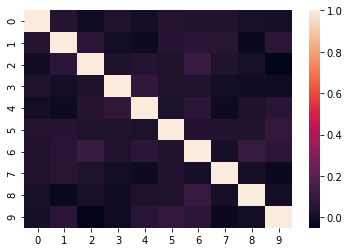

Key:
0 Ava DuVernay’s racial inequality documentary The 13th will open the 54th New York film festival, marking the first time a non-fiction film has been chosen to kick off the event., The Netflix project, which debuts globally on the streaming platform and in select theaters on 7 October, examines why the US has produced the highest rate of incarceration in the world, with the majority of those imprisoned being African American. The title of the film refers to the 13th amendment to the constitution: “Neither slavery nor involuntary servitude, except as a punishment for crime whereof the party shall have been duly convicted, shall exist within the United States.”, A statement reported that “the progression from that second qualifying clause to the horrors of mass incarceration and the prison industry in the US is laid out by DuVernay” in the documentary., The film is said to be a mix of archival footage and testimonies from activists, politicians and historians, including Michelle Ale

3 Angelina Jolie is expected to take on the role played by Lauren Bacall in Murder on the Orient Express, in an upcoming remake of the 1974 classic, directed by Kenneth Branagh., Branagh’s film, like Sidney Lumet’s original, is based on Agatha Christie’s 1934 mystery novel, which revolves around special detective Hercule Poirot and his efforts to solve a murder case aboard the famous train., Branagh will star as Poirot, played by Albert Finney in Lumet’s adaptation. According to the Hollywood Reporter, Jolie is in final talks to portray Mrs Harriet Hubbard, one of the passengers who’s deemed a suspect., The rest of the ensemble has yet to be announced – but expect it to be star-packed. On top of starring Finney and Bacall, Lumet’s film also featured Ingrid Bergman and Sean Connery., Shooting is expected to begin in November, with locations including London and Malta. Green Lantern writer Michael Green penned the screenplay., Jolie has appeared on the big screen only intermittently in r

6 Since the majority of the buzz surrounding Paul Feig’s new female-led Ghostbusters has focused on the man-babies angry about gender, we haven’t spent enough time praising the choice of leads., Kristen Wiig has mostly stuck to indie-based supporting roles since breaking out in 2011’s Oscar-nominated Bridesmaids, but playing the awkward academic with a paranormal past in this week’s big budget sci-fi comedy takes her back to the multiplex. The film might underwhelm in parts but she remains a winning comic presence throughout., But what have been her greatest roles?, Wiig had been part of Saturday Night Live for two years when she made her first memorable big-screen appearance. It’s a minor role in Judd Apatow’s engaging romantic comedy, but in a small amount of screen time she emerged as an effortless scene-stealer. As the snippy E! employee with limited social skills, she turned every glance into a punchline., Her magnum opus arrived in 2011 with a film that finally gave her the lead 

9 For Jessica Chastain, there’s a constant trait found in her best roles: the characters she plays are obsessive. In Zero Dark Thirty she played the female operative behind locating Osama bin Laden. Those obsessive qualities were also found in Crimson Peak’s Lucille Sharpe, as well as Anna Morales, the Lady Macbeth-type in A Most Violent Year. But Elizabeth Sloane, the tenacious lobbyist she plays here, is perhaps her most obsessive character yet., Director John Madden (reuniting with Chastain following 2010’s The Debt) opens on a lucid Sloane peering directly into the camera. “Lobbying is about foresight,” she says. “Anticipating your opponent’s moves and devising counter-measures. I was hired to win.” From the outset of Miss Sloane, first-time screenwriter Jonathan Perera establishes Sloane as a fighter with laser-like focus on her prize., In what we come to learn is a flash-forward, Sloane is seen defending herself in a Senate hearing. The sequence eerily calls to mind Hillary Clint

In [46]:
##creating a heatmap of the similarity matrix
similarity = np.asarray(np.asmatrix(x_train_lsa) * np.asmatrix(x_train_lsa).T)
sim_matrix=pd.DataFrame(similarity,index=x_train).iloc[0:10,0:10]
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])

Here we visualize our similarity matrix. Unfortunately, even though these articles are written by the same individual they do not seem to bear much resemblance to each other at all.

Finally, an attempt at some clustering.

In [41]:
##clustering via KMeans
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

y_train_pred = KMeans(n_clusters=10).fit_predict(X_train)

print(pd.crosstab(y_train_pred, Y_train))

text_source  Andrew Pulver  Ben Child  Benjamin Lee  Gwilym Mumford  \
row_0                                                                 
0                        1          6             8               1   
1                        0          0             0               0   
2                       12          1            12              11   
3                        0          0             0               0   
4                        0          0             0               0   
5                        0          0             2               1   
6                        0          4             0               1   
7                        3          2             1               1   
8                        0          3             7               1   
9                        0          1             3               4   

text_source  Jordan Hoffman  Nigel M Smith  Peter Bradshaw  Ryan Gilbey  \
row_0                                                                   

In [43]:
##clustering via minibatch KMeans
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=10,
    batch_size=200)
minibatchkmeans.fit(X_train)

predict_mini_train = minibatchkmeans.predict(X_train)

print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(predict_mini_train, y_train_pred))
print(pd.crosstab(predict_mini_train, Y_train))

Comparing k-means and mini batch k-means solutions:
col_0   0  1   2  3  4  5  6   7   8  9
row_0                                  
0       0  0   1  0  0  0  0   0   0  0
1      44  0  17  0  0  0  0  27   0  0
2       0  0   1  0  0  0  0   0   0  0
3       0  0   0  2  1  0  0   0   2  3
4       8  0   0  0  0  4  7  12  10  6
5       0  1  46  0  0  0  0   0   0  0
6       0  0   0  0  0  0  0   0   0  2
7       0  0   0  0  0  0  1   0   0  0
8       1  0   0  0  0  0  0   0   0  0
9       2  0   8  0  0  0  0   0   0  0
text_source  Andrew Pulver  Ben Child  Benjamin Lee  Gwilym Mumford  \
row_0                                                                 
0                        0          0             0               0   
1                        5          6            10               5   
2                        0          0             0               0   
3                        0          2             1               1   
4                        1          9     

As we can see from our clustering results, it doesn't seem that the metric we're using to compare articles with one another (bagged words) captures the variation. The clusters are all over, and nowhere near the shape we'd like to see.

In [48]:
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(X_train, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train)

labels = ms.labels_

cluster_centers = ms.cluster_centers_

n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))
print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(Y_train,labels))

Number of estimated clusters: 7
Comparing the assigned categories to the ones in the data:
col_0             0  1  2  3  4  5  6
author                               
Andrew Pulver    16  0  0  0  0  0  0
Ben Child        16  1  0  0  0  0  0
Benjamin Lee     33  0  0  0  0  0  0
Gwilym Mumford   17  1  1  0  0  1  0
Jordan Hoffman   23  0  0  0  0  0  0
Nigel M Smith    31  0  0  1  0  0  0
Peter Bradshaw   52  0  0  0  0  0  1
Ryan Gilbey       5  0  0  0  1  0  0
Stuart Heritage   6  0  0  0  0  0  0


Attempting to cluster by meanshift doesn't yield much better results. It only identifies 7 unique clusters (instead of the 10 different authors we have) and most of the articles seem to fall into one large cluster.

In [57]:
from sklearn.cluster import SpectralClustering

n_clusters=5

sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(X_train)

predict=sc.fit_predict(X_train)

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(Y_train,predict))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Comparing the assigned categories to the ones in the data:
col_0             0  1  2  3  4
text_source                    
Andrew Pulver    16  0  0  0  0
Ben Child        17  0  0  0  0
Benjamin Lee     31  1  1  0  0
Gwilym Mumford   20  0  0  0  0
Jordan Hoffman   23  0  0  0  0
Nigel M Smith    32  0  0  0  0
Peter Bradshaw   52  0  0  1  0
Ryan Gilbey       6  0  0  0  0
Stuart Heritage   5  0  0  0  1


We run into a similar problem with spectral clustering. This detects even less clusters (only 5!) and again, sorts most of the articles into one large cluster.

## Conclusion

All in all, this was an interesting problem to tackle and one where feature engineering was particularly difficult. Because I wasn't able to model the data particularly well with any of the techniques that I applied, I'm inclined to believe that I need a bit more data and to take a look at more articles - though my machine lacks the computational power to parse thousands of articles instead of the only hundreds that I used.

Of the limited conclusions that I can draw, of the techniques that I applied it seems that a supervised approach performed the best (Logistic Regression) though it was not of itself particularly convincing.